### A quick tutorial example for finding nearest-neighbors using sklearn


In [12]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
#from sklearn.neighbors import NearestNeighbors
import sklearn
import sklearn.neighbors
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import ANSStools as atp
#from yodiipy import ANSStools as atp
#
import random
import geopy




(0.0, 1.0)

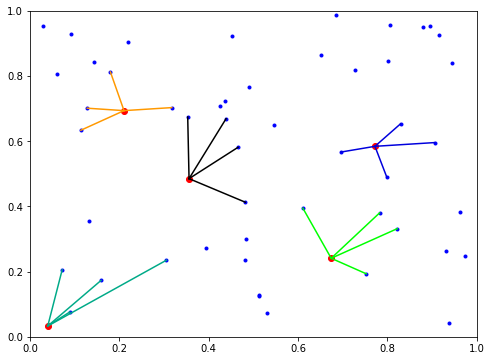

In [30]:
n1=50
n2 = 5
n_NN=4

XY_bg = numpy.array([numpy.random.uniform(size=n1), numpy.random.uniform(size=n1)]).T
XY_fg = numpy.array([numpy.random.uniform(size=n2), numpy.random.uniform(size=n2)]).T
#
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=n_NN, algorithm='ball_tree').fit(XY_bg)
#
distances, indices = nbrs.kneighbors(XY_fg)
#
plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(*XY_bg.T, marker='.', ls='', color='b', zorder=1)
ax.plot(*XY_fg.T, marker='o', ls='', color = 'r', zorder=2)
#
# make a color index:
color_idx = numpy.linspace(0, 1, len(XY_fg)+1)
cmap = plt.cm.spectral
#
for k, (ixs, dists, (x_fg, y_fg)) in enumerate(zip(indices, distances, XY_fg)):
    #
    clr = cmap(color_idx[k])
    #
    for (x_bg, y_bg),r in zip(XY_bg[ixs], dists):
        ax.plot([x_fg, x_bg], [y_fg, y_bg], ls='-', color=clr)
#
ax.set_ylim(0.,1.)
ax.set_xlim(0.,1.)

